# Imports

In [1]:
import sys
sys.path.append('.././')

In [2]:
import warnings
import os
import networkx as nx
import osmnx as ox
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt 

from geonetworkx.tools import get_alpha_shape_polygon
from shapely.geometry import Point, Polygon, MultiPolygon, LineString, MultiLineString
from shapely.errors import ShapelyDeprecationWarning

from app.utils import plug_shape_holes, grid_interpolate, colorize_image, convert_image_to_bytes_url, get_gdf_corners, \
    prepare_interpolation_points, extract_contours_from_singleband_raster
from app.utils import PALETTE

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

from prettymapp.geo import get_aoi
from prettymapp.osm import get_osm_geometries
from prettymapp.plotting import Plot
from prettymapp.settings import STYLES

import pydeck as pdk

from app.utils import prepare_buffer_layer, prepare_source_layer, prepare_start_point_layer, prepare_edges_layer, \
    prepare_acc_edges_layer, prepare_nodes_layer, prepare_acc_nodes_layer

# Locations

In [3]:
montreal = [45.502042, -73.563069]
terrebonne = [45.719903, -73.674858]
mount_royal = [45.503879, -73.603036]
paris = [48.864577, 2.356842]
barcelona = [41.404367, 2.172034]
amsterdam = [52.372094, 4.900894]

In [4]:
# aoi = get_aoi(coordinates=tuple(paris), radius=650, rectangular=False)
# df = get_osm_geometries(aoi=aoi)
# fig = Plot(
#     df=df,
#     aoi_bounds=aoi.bounds,
#     bg_shape='circle',
#     draw_settings=STYLES["Peach"]
# ).plot_all()

# Config

In [63]:
source_ = amsterdam
colormap = plt.cm.YlOrRd
padding_geo = 1 / 111111 * 10
padding = 10
offset = 50

alpha = 92
plug_holes = True
force_single = False

distance = 500
interval = 100
cell_size = 5

cap_style = 'square'

# algo = 'idw'
algo = 'tin'

In [64]:
# Build the graph
graph = ox.graph_from_point(source_, network_type='walk', dist=distance + 250)
nodes, edges = ox.utils_graph.graph_to_gdfs(graph)

# Get UTM crs for distance based geoprocessing
utm_crs = nodes.estimate_utm_crs()

# Construct GeoDataFrames
source = gpd.GeoDataFrame(geometry=[Point(source_[::-1])], crs='epsg:4326')
buffer = source.to_crs(utm_crs).buffer(distance).to_crs('epsg:4326')

# Merge source to graph
# gnx.spatial_points_merge(graph, source, inplace=True)

# Clip
nodes = nodes.clip(buffer)
edges = edges.clip(buffer)

# Find the closest node to source_
start_node = ox.nearest_nodes(graph, source_[1], source_[0])

# Get start node as gdf for plotting
start_point = nodes[nodes.index == start_node].copy()

# Calculate isochrone
subgraph = nx.ego_graph(graph, start_node, radius=distance, distance='length')
acc_nodes, acc_edges = ox.utils_graph.graph_to_gdfs(subgraph)

In [65]:
# Convex shape
shape_convex = acc_nodes.unary_union.convex_hull.buffer(padding_geo)
shape_convex_df = gpd.GeoDataFrame(geometry=[shape_convex], crs='epsg:4326')
shape_convex_area = round(shape_convex_df.to_crs(utm_crs).iloc[0].geometry.area / 1000000, 2)

# Concave shape
pts = list(acc_nodes.to_crs(utm_crs).geometry.apply(lambda p: (p.x, p.y)))
shape_concave = get_alpha_shape_polygon(pts, alpha)

# Concave shape - CONDITION - no holes
if plug_holes:
    shape_concave = plug_shape_holes(shape_concave)

# Concave shape - CONDITION - single part geometry
if force_single:
    while shape_concave.geom_type.lower() == 'multipolygon':
        if new_alpha == 100:
            break
        new_alpha += 1

        # with st.empty():
        #     st.write('Overwritten alpha percentile:', new_alpha)

        shape_concave = get_alpha_shape_polygon(pts, new_alpha)
        if plug_holes:
            shape_concave = plug_shape_holes(shape_concave)

shape_concave = shape_concave.buffer(padding)
shape_concave_area = round(shape_concave.area / 1000000)
shape_concave_df = gpd.GeoDataFrame(geometry=[shape_concave], crs=utm_crs).to_crs(
    'epsg:4326')

# Offset shape
shape_offset = acc_edges.to_crs(utm_crs).buffer(offset, cap_style=cap_style).unary_union
shape_offset_area = round(shape_offset.area / 1000000)
shape_offset_df = gpd.GeoDataFrame(geometry=[shape_offset], crs=utm_crs).to_crs(
    'epsg:4326')

In [66]:
buffer_layer = prepare_buffer_layer(buffer)
source_layer = prepare_source_layer(source)
start_point_layer = prepare_start_point_layer(start_point)
edges_layer = prepare_edges_layer(edges)
acc_edges_layer = prepare_acc_edges_layer(acc_edges)
nodes_layer = prepare_nodes_layer(nodes)
acc_nodes_layer = prepare_acc_nodes_layer(acc_nodes)

In [67]:
# Viewport
viewport = pdk.data_utils.compute_view(points=[[p.xy[0][0], p.xy[1][0]] for p in nodes.geometry.to_list()],
                                       view_proportion=0.9)

In [68]:
pdk.Deck(
                    initial_view_state=viewport,
                    layers=[
                        buffer_layer,
                        pdk.Layer(
                            type="GeoJsonLayer",
                            data=shape_concave_df,
                            # get_fill_color=PALETTE['teal'] + [100],
                            # get_line_color=PALETTE['teal'] + [200],
                            get_fill_color=PALETTE['aquamarine'] + [100],
                            get_line_color=PALETTE['aquamarine'] + [200],
                            line_width_max_pixels=1,
                            stroked=True,
                            filled=True,
                            pickable=True,
                            auto_highlight=True,
                        ),
                        source_layer,
                        start_point_layer,
                        edges_layer,
                        acc_edges_layer,
                        nodes_layer,
                        acc_nodes_layer
                    ]
                )

{
  "initialViewState": {
    "latitude": 52.372166404129786,
    "longitude": 4.9000807713864285,
    "zoom": 14
  },
  "layers": [
    {
      "@@type": "GeoJsonLayer",
      "data": [
        {
          "geometry": {
            "coordinates": [
              [
                [
                  4.90823424099833,
                  52.37197567886712
                ],
                [
                  4.908179911857703,
                  52.371535888170534
                ],
                [
                  4.908055418212883,
                  52.37110147442551
                ],
                [
                  4.9078619609733,
                  52.37067662103719
                ],
                [
                  4.9076014050218095,
                  52.37026541922794
                ],
                [
                  4.907276261186327,
                  52.369871828649856
                ],
                [
                  4.906889662000359,
                  52.36949963926844
                ],
                [
                  4.906445331488103,
                  52.36915243488328
                ],
                [
                  4.90594754926696,
                  52.36883355863683
                ],
                [
                  4.905401109314373,
                  52.368546080842016
                ],
                [
                  4.904811273796823,
                  52.368292769438085
                ],
                [
                  4.904183722405737,
                  52.36807606335805
                ],
                [
                  4.903524497687648,
                  52.367898049063164
                ],
                [
                  4.902839946894089,
                  52.36776044046981
                ],
                [
                  4.902136660909517,
                  52.36766456246121
                ],
                [
                  4.901421410843346,
                  52.367611338141955
                ],
                [
                  4.900701082894169,
                  52.367601279957725
                ],
                [
                  4.899982612110685,
                  52.36763448476534
                ],
                [
                  4.899272915684171,
                  52.36771063290023
                ],
                [
                  4.898578826411857,
                  52.36782899125061
                ],
                [
                  4.897907026968936,
                  52.36798842030864
                ],
                [
                  4.897263985619276,
                  52.36818738513114
                ],
                [
                  4.896655893981356,
                  52.36842397010481
                ],
                [
                  4.89608860744653,
                  52.36869589737445
                ],
                [
                  4.8955675888215975,
                  52.3690005487573
                ],
                [
                  4.8950978557371565,
                  52.36933499093359
                ],
                [
                  4.894683932327558,
                  52.36969600367148
                ],
                [
                  4.894329805647662,
                  52.3700801108154
                ],
                [
                  4.894038887246693,
                  52.370483613740575
                ],
                [
                  4.893813980270308,
                  52.37090262695206
                ],
                [
                  4.89365725240937,
                  52.37133311548665
                ],
                [
                  4.8935702149580775,
                  52.371770933757745
                ],
                [
                  4.89355370818564,
                  52.37221186546992
                ],
                [
                  4.893607893165215,
                  52.37265166421902
         

In [69]:
plot(graph)

NameError: name 'plot' is not defined

# IMAGE - Nodes to surface

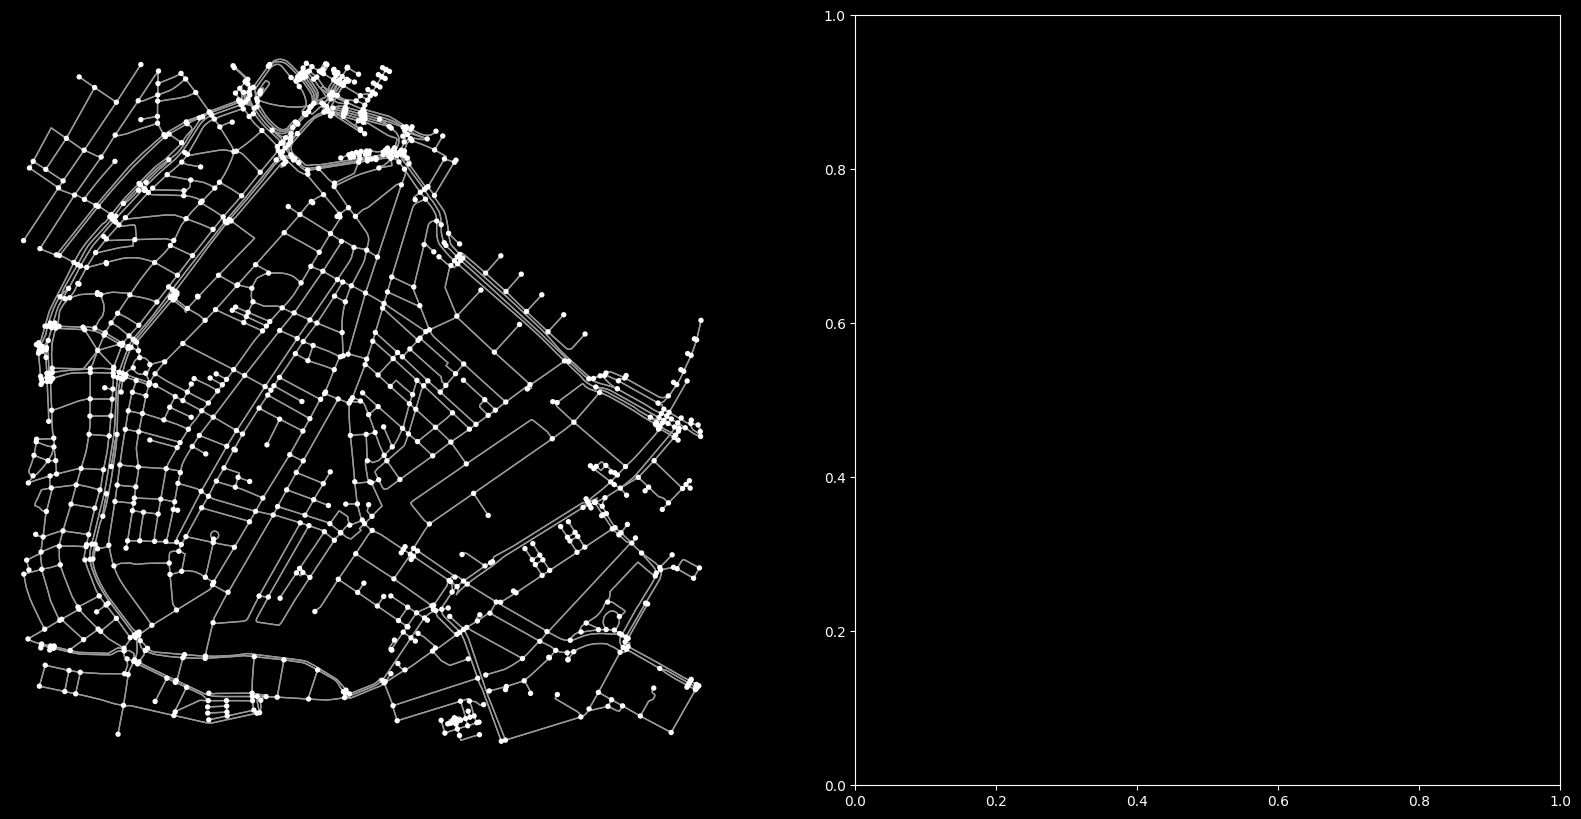

<Figure size 640x480 with 0 Axes>

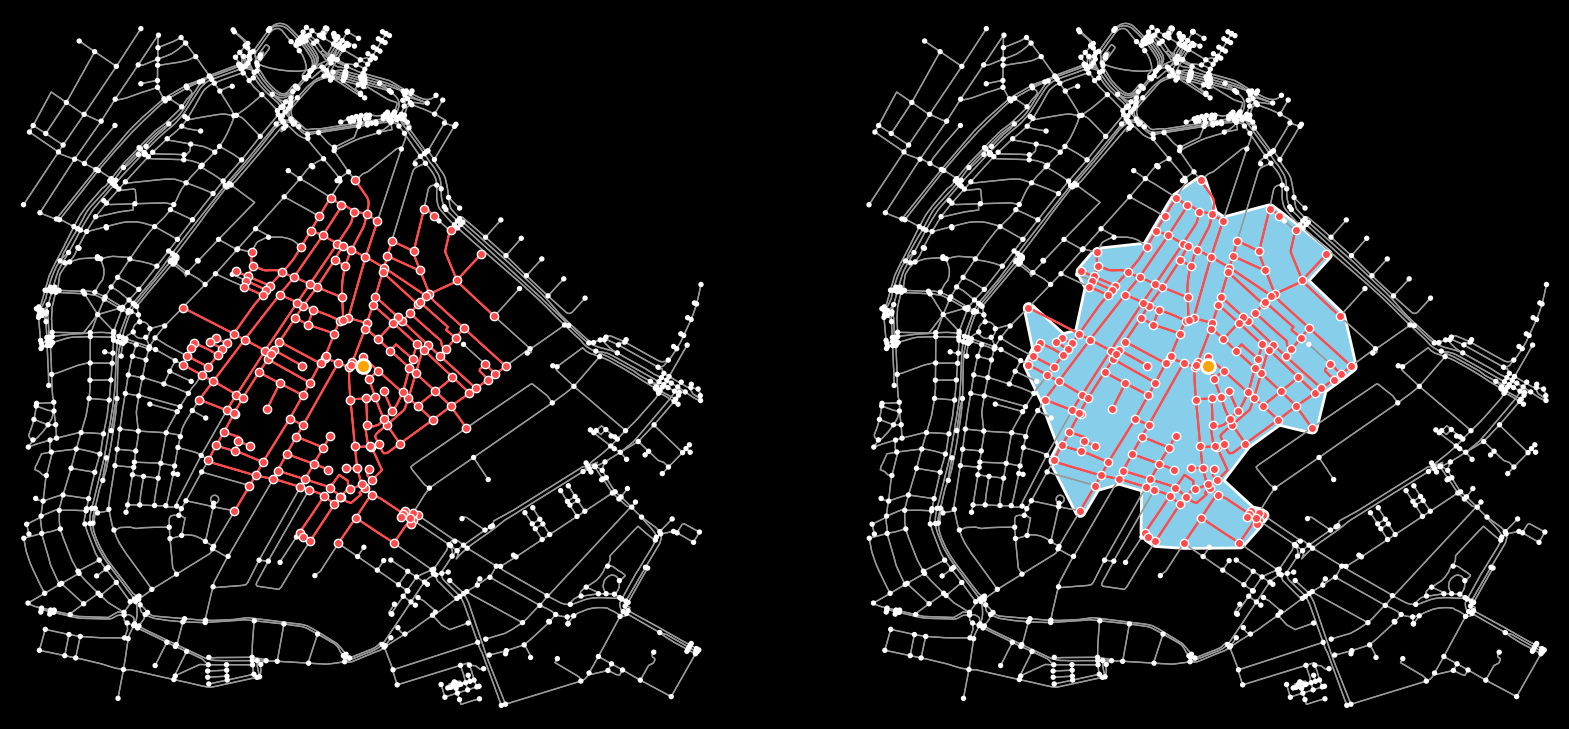

<Figure size 640x480 with 0 Axes>

In [105]:
plt.style.use('dark_background')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

''' Plot 1 '''

# Plot the 
_, ax1 = ox.plot_graph(graph, ax=ax1)

# Plot accessible links
acc_edges.plot(ax=ax1, color='#FF4B4B', zorder=1)

# Plot accessible nodes
acc_nodes.plot(ax=ax1, color='#FF4B4B', edgecolor='white')

# Plot source
source.plot(ax=ax1, color='orange', zorder=5, markersize=100, edgecolor='white', linewidth=2)

# Plot shape
# shape_concave_df.plot(ax=ax1, color='skyblue', zorder=0, markersize=100, edgecolor='white', linewidth=2)


''' Plot 2 '''

# Plot the 
_, ax2 = ox.plot_graph(graph, ax=ax2)

# Plot accessible links
acc_edges.plot(ax=ax2, color='#FF4B4B', zorder=1)

# Plot accessible nodes
acc_nodes.plot(ax=ax2, color='#FF4B4B', edgecolor='white')

# Plot source
source.plot(ax=ax2, color='orange', zorder=5, markersize=100, edgecolor='white', linewidth=2)

# Plot shape
shape_concave_df.plot(ax=ax2, color='skyblue', zorder=0, markersize=100, edgecolor='white', linewidth=2)

fig

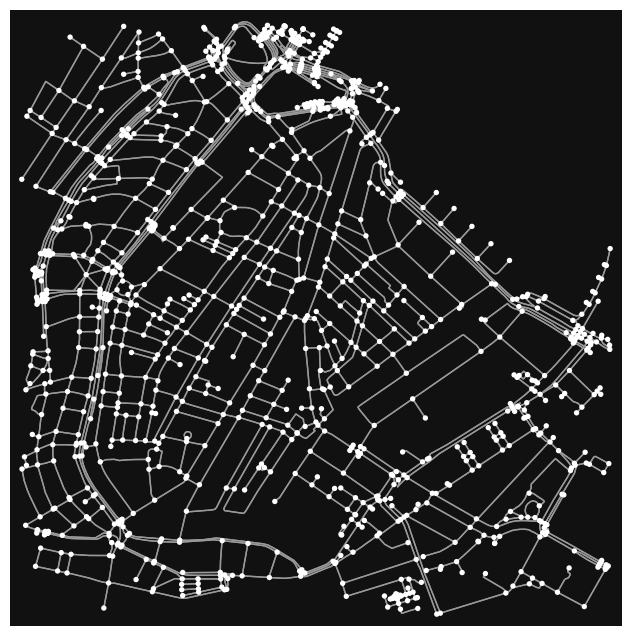

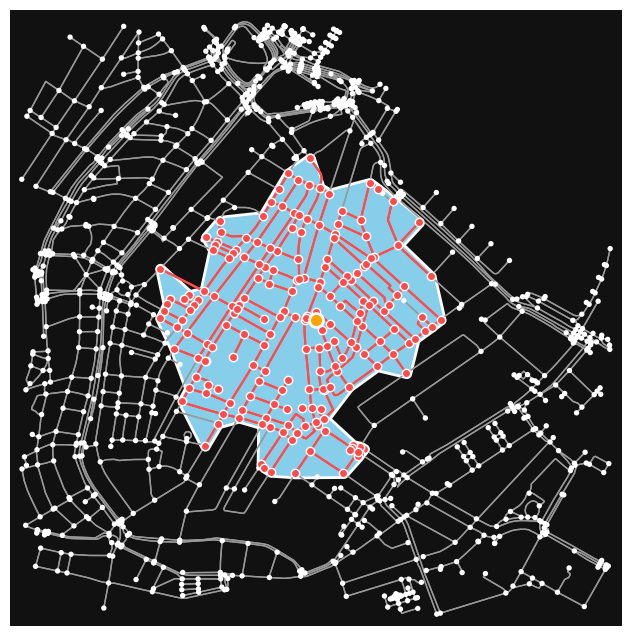

<Figure size 640x480 with 0 Axes>

In [84]:
# Plot the graph
fig, ax = ox.plot_graph(graph)

# Plot accessible links
acc_edges.plot(ax=ax, color='#FF4B4B', zorder=1)

# Plot accessible nodes
acc_nodes.plot(ax=ax, color='#FF4B4B', edgecolor='white')

# Plot source
source.plot(ax=ax, color='orange', zorder=5, markersize=100, edgecolor='white', linewidth=2)

# Plot shape
shape_concave_df.plot(ax=ax, color='skyblue', zorder=0, markersize=100, edgecolor='white', linewidth=2)


fig

AttributeError: 'Figure' object has no attribute 'get_gridspec'

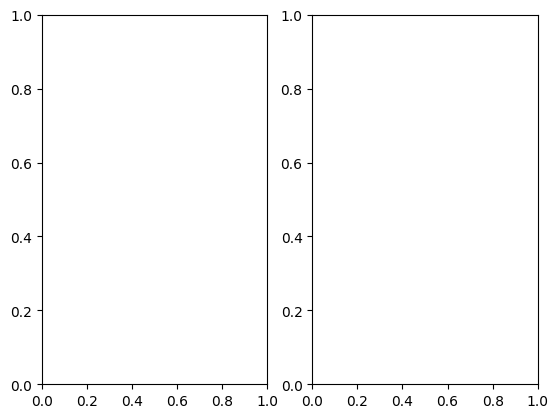

In [93]:
# Create a new figure with 2 columns and 1 row
fig_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

# Add the existing figures to the new figure's subplots
fig_.add_subfigure(fig)  # Assuming fig1 contains an image plot
# ax2.plot(fig)  # Assuming fig2 contains a line plot

# Optionally, you can customize the appearance of the new figure
fig_.suptitle('Two Plots')
fig_.tight_layout()

# Show the new figure
plt.show()

In [76]:
a[0] = fig

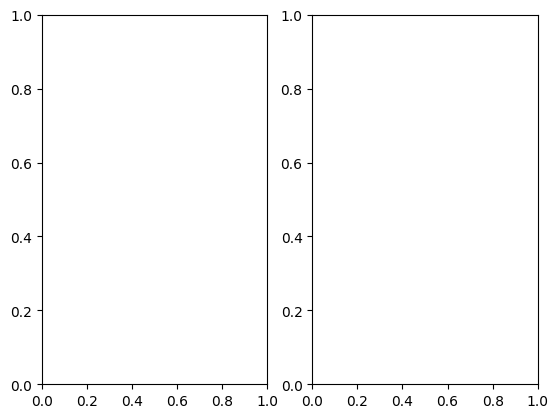

In [77]:
f